In [1]:
# This code can be downloaded as a Python script and run as:
# python full_vs_EM_any_dataset.py random_state dataset_name test_proportion val_proportion M_method M_alpha M_beta
#     test_proportion: The test proportion is from all the available true labels
#     val_proportion: The validation proportion is from the remaining training proportion with the true labels

def is_interactive():
    import __main__ as main
    return not hasattr(main, '__file__')

import sys
import numpy
import matplotlib

if is_interactive():
    %matplotlib inline
    sys.path.append('../')
    # Define all the variables for this experiment
    random_state = 0
    dataset_name = 'mnist'
    train_val_test_proportions = numpy.array([0.5, 0.2, 0.3]) # Train, validation and test proportions
    w_wt_drop_proportions = numpy.array([0.9, 0.1])           # Train set: for weak, for true [the rest to drop]
    M_method_list = ['odd_even', 'random_weak', 'noisy', 'random_noise', 'IPL', 'quasi_IPL'] # Weak labels in training
    alpha = 0.9  # alpha = 0 (all noise), alpha = 1 (no noise)
    beta = 1 - alpha # beta = 1 (all noise), beta = 0 (no noise)
    max_epochs = 1000  # Upper limit on the number of epochs
else:
    random_state = int(sys.argv[1])
    weak_prop = float(sys.argv[2])
    alpha = float(sys.argv[3]) # alpha = 0 (all noise), alpha = 1 (no noise)
    dataset_name = 'mnist'
    train_val_test_proportions = numpy.array([0.5, 0.2, 0.3]) # Train, validation and test proportions
    w_wt_drop_proportions = numpy.array([weak_prop, 0.1])           # Train set: for weak, for true [the rest to drop]
    M_method_list = ['odd_even', 'random_weak', 'noisy', 'random_noise', 'IPL', 'quasi_IPL'] # Weak labels in training
    beta = 1 - alpha # beta = 1 (all noise), beta = 0 (no noise)
    max_epochs = 1000  # Upper limit on the number of epochs
    matplotlib.use('Agg')
    
import keras
from keras import backend as K

import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.utils import shuffle
from wlc.WLweakener import computeM, generateWeak, weak_to_index, binarizeWeakLabels
from experiments.visualizations import plot_history
from experiments.visualizations import plot_multilabel_scatter

cmap = plt.cm.get_cmap('tab20')

Using TensorFlow backend.


# 1. Generation of a dataset
## 1.a. Obtain dataset with true labels

In [2]:
from keras.datasets import cifar10, mnist

# cifar100.load_data(label_mode='fine')

(x_train, y_train), (x_test, y_test) = mnist.load_data()
X = numpy.concatenate((x_train, x_test))
y = numpy.concatenate((y_train, y_test)).flatten()
X, y = shuffle(X, y)

n_samples = X.shape[0]
n_features = sum(X[0].shape)
n_classes = 10
Y = label_binarize(y, range(n_classes))
print('n_samples = {}'.format(n_samples))
print('n_features = {}'.format(n_features))

n_samples = 70000
n_features = 56


## 1.b. Divide into training, validation and test

- Validation and test will always have only true labels, while the training may have weak labels as well

- $S_{train} = \{S_{wt-train}, S_{w-train}\} = [\{(x_i, b_i, y_i), i = 1,...,n\} X x Z x C, \{(x_i, b_i), i = 1,...,n\} \in X x Z\}]$
- $S_{val} = \{(x_i, y_i), i = 1,...,n\} \in X x C$
- $S_{test} = \{(x_i, y_i), i = 1,...,n\} \in X x C$

In [3]:
#train_val_test_proportions = numpy.array([0.5, 0.2, 0.3])
print('Original proportions for the 3 partitions (train, validation and test)')
print(train_val_test_proportions)
# Ensure that all proportions sum to 1
train_val_test_proportions /= train_val_test_proportions.sum()
print('Proportions where to split')
train_val_test_proportions = numpy.cumsum(train_val_test_proportions)
print(train_val_test_proportions)
print('Indices where to split (from a total of {} samples)'.format(X.shape[0]))
indices = (train_val_test_proportions*X.shape[0]).astype(int)[:-1]
print(indices)

# # Divide into training, validation and test
X_train, X_val, X_test = numpy.array_split(X, indices)
Y_train, Y_val, Y_test = numpy.array_split(Y, indices)
y_train, y_val, y_test = numpy.array_split(y, indices)

print('Final sizes')
print('Training samples = {}'.format(X_train.shape[0]))
print('Validation samples = {}'.format(X_val.shape[0]))
print('Test samples = {}'.format(X_test.shape[0]))

Original proportions for the 3 partitions (train, validation and test)
[0.5 0.2 0.3]
Proportions where to split
[0.5 0.7 1. ]
Indices where to split (from a total of 70000 samples)
[35000 49000]
Final sizes
Training samples = 35000
Validation samples = 14000
Test samples = 21000


## 1.c. Generate weakening processes

- This will generate weak labels given the specified mixing process.
- It will also show 3 plots with the true labels, weak labels and the corresponding rows of the mixing matrix M.
- In all the mixing processes we remove the unlabeled option as this can be seen as the all labels (if we assume that every samples belongs to one class)

In [4]:
#M_method_list = ['odd_even', 'random_weak', 'noisy', 'random_noise', 'IPL', 'quasi_IPL']
#alpha = 0.1
#beta = 1 - alpha

M_list = []
for i, key in enumerate(M_method_list):
    M_list.append(computeM(n_classes, alpha=alpha, beta=beta, method=key, seed=random_state,
                           unsupervised=False))

    print('\nMixing matrix for set {} of type {} and shape = {}\n{}'.format(
        i, key, M_list[-1].shape, numpy.round(M_list[-1], decimals=2)))


Mixing matrix for set 0 of type odd_even and shape = (1024, 10)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Mixing matrix for set 1 of type random_weak and shape = (1024, 10)
[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0.9]
 [0.  0.  0.  ... 0.  0.9 0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]

Mixing matrix for set 2 of type noisy and shape = (10, 10)
[[0.9  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.9  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.9  0.01 0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.9  0.01 0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.9  0.01 0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.9  0.01 0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.9  0.01 0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.9  0.01 0.01]
 [0.01 0.01 0.01 0.01 0.01 0.01 0.0

## 1.d. Divide training into weak portions

- Currently every weak partition is of the same size
- We will assume that a proportion of each weak set has been annotated with the true labels

In [5]:
#w_wt_drop_proportions = numpy.array([0.1, 0.1]) # for weak, for true [the rest to drop]
cut_indices = (w_wt_drop_proportions.cumsum()*X_train.shape[0]).astype(int)
print('Indices for the cuts = {}'.format(cut_indices))

X_w_train, X_wt_train, _ = numpy.array_split(X_train, cut_indices)
y_w_train, y_wt_train, _ = numpy.array_split(y_train, cut_indices)
Y_w_train, Y_wt_train, _ = numpy.array_split(Y_train, cut_indices)
print('Portion with only weak labels = {}'.format(X_w_train.shape[0]))
print('Portion with weak and true labels = {}'.format(X_wt_train.shape[0]))

X_w_train_list = numpy.array_split(X_w_train, len(M_method_list))
y_w_train_list = numpy.array_split(y_w_train, len(M_method_list))
Y_w_train_list = numpy.array_split(Y_w_train, len(M_method_list))
Z_w_train_list = []
z_w_train_list = []

print('## Portion with only weak labels ##')
for i, M in enumerate(M_list):
    print('Generating weak labels for set {} with mixing process {}'.format(i, M_method_list[i]))
    z_w_train_list.append(generateWeak(y_w_train_list[i], M))
    Z_w_train_list.append(binarizeWeakLabels(z_w_train_list[i], n_classes))
    
    print('Total shape = {}'.format(z_w_train_list[-1].shape))
    print('Sample of z labels\n{}'.format(z_w_train_list[-1][:3]))
    print('Sample of Z labels\n{}'.format(Z_w_train_list[-1][:3]))
    
X_wt_train_list = numpy.array_split(X_wt_train, len(M_method_list))
y_wt_train_list = numpy.array_split(y_wt_train, len(M_method_list))
Y_wt_train_list = numpy.array_split(Y_wt_train, len(M_method_list))
Z_wt_train_list = []
z_wt_train_list = []

print('## Portion with both weak and true labels ##')
for i, M in enumerate(M_list):
    print('Generating weak labels for set {} with mixing process {}'.format(i, M_method_list[i]))
    z_wt_train_list.append(generateWeak(y_wt_train_list[i], M))
    Z_wt_train_list.append(binarizeWeakLabels(z_wt_train_list[i], n_classes))
    
    print('Total shape = {}'.format(z_wt_train_list[-1].shape))
    print('Sample of z labels\n{}'.format(z_wt_train_list[-1][:3]))
    print('Sample of Z labels\n{}'.format(Z_wt_train_list[-1][:3]))

Indices for the cuts = [31500 35000]
Portion with only weak labels = 31500
Portion with weak and true labels = 3500
## Portion with only weak labels ##
Generating weak labels for set 0 with mixing process odd_even
Total shape = (5250,)
Sample of z labels
[682 341 341]
Sample of Z labels
[[1 0 1 0 1 0 1 0 1 0]
 [0 1 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 1 0 1 0 1]]
Generating weak labels for set 1 with mixing process random_weak
Total shape = (5250,)
Sample of z labels
[16 64 64]
Sample of Z labels
[[0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]]
Generating weak labels for set 2 with mixing process noisy
Total shape = (5250,)
Sample of z labels
[  8   4 256]
Sample of Z labels
[[0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0 0]]
Generating weak labels for set 3 with mixing process random_noise
Total shape = (5250,)
Sample of z labels
[16  2  8]
Sample of Z labels
[[0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0]]
Generating weak labels for

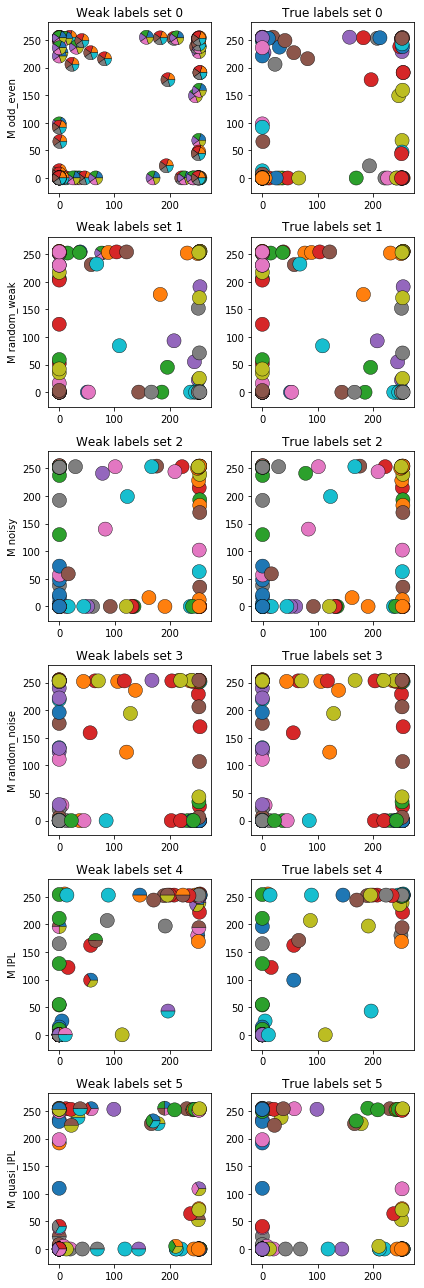

In [6]:
from experiments.visualizations import plot_multilabel_scatter

fig = plt.figure(figsize=(6, len(z_wt_train_list)*3))
j = 1
for i in range(len(Z_wt_train_list)):
    X_sample = X_wt_train_list[i][:100].reshape((100, -1))
    ax = fig.add_subplot(len(Z_wt_train_list), 2, j)
    _ = plot_multilabel_scatter(X_sample, Z_wt_train_list[i][:100], fig=fig,
                                ax=ax, title='Weak labels set {}'.format(i), cmap=cmap)
    ax.set_ylabel('M {}'.format(M_method_list[i]))
    ax = fig.add_subplot(len(Z_wt_train_list), 2, j+1)
    _ = plot_multilabel_scatter(X_sample, Y_wt_train_list[i][:100], fig=fig,
                                ax=ax, title='True labels set {}'.format(i), cmap=cmap)
    j += 2
fig.tight_layout()

# Define a common model

In [7]:
from keras.callbacks import EarlyStopping, Callback
from keras import regularizers

def log_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, K.epsilon(), 1.0-K.epsilon())
    out = -y_true*K.log(y_pred)
    return K.mean(out, axis=-1)

#max_epochs = 1000

# Callback to show performance per epoch in the same line
class EpochCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        print('\rEpoch {}, val_loss = {:.2e}, val_acc = {:.2f}'.format(epoch, logs['val_loss'], logs['val_acc']), end=' ')

# Callback for early stopping
epoch_callback = EpochCallback()
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=int(max_epochs/20), 
                               verbose=2, mode='auto', baseline=None,
                               restore_best_weights=True)

def make_model(loss, l2=0.0):
    # Careful that it is ussing global variables for the input and output shapes
    numpy.random.seed(random_state)
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(Y.shape[1], input_shape=X[0].shape,
                                 kernel_regularizer=regularizers.l2(l2),
                                 activation='softmax'))
    model.compile(optimizer='adam', loss=loss, metrics=['ce', 'mse', 'acc'])
    return model

# Keyword arguments for the fit function
fit_kwargs = dict(validation_data=(X_val, Y_val), epochs=max_epochs, verbose=0,
                  callbacks=[early_stopping, epoch_callback], shuffle=True)

# Save the final model for each method
final_models = {}

# Fully supervised (upperbound)

Train with all true labels

Evaluating l2 regularization = 1e-10
Epoch 113, val_loss = 2.74e-01, val_acc = 0.83 Restoring model weights from the end of the best epoch
Epoch 114, val_loss = 2.64e-01, val_acc = 0.84 Epoch 00115: early stopping


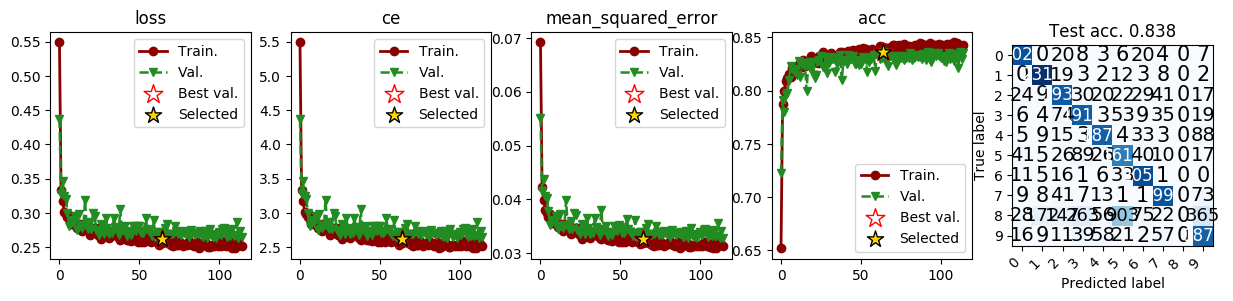

<Figure size 500x400 with 0 Axes>

Evaluating l2 regularization = 1e-09
Epoch 174, val_loss = 1.38e-01, val_acc = 0.91 Restoring model weights from the end of the best epoch
Epoch 175, val_loss = 1.38e-01, val_acc = 0.91 Epoch 00176: early stopping


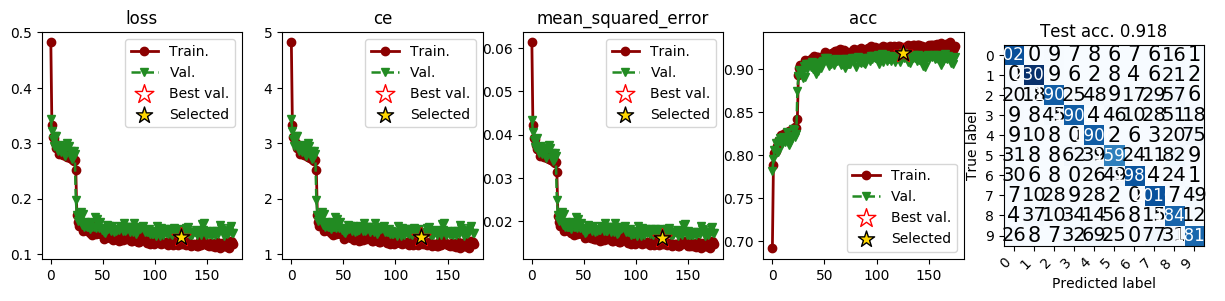

<Figure size 500x400 with 0 Axes>

Evaluating l2 regularization = 1e-08
Epoch 117, val_loss = 1.39e-01, val_acc = 0.91 Restoring model weights from the end of the best epoch
Epoch 118, val_loss = 1.49e-01, val_acc = 0.91 Epoch 00119: early stopping


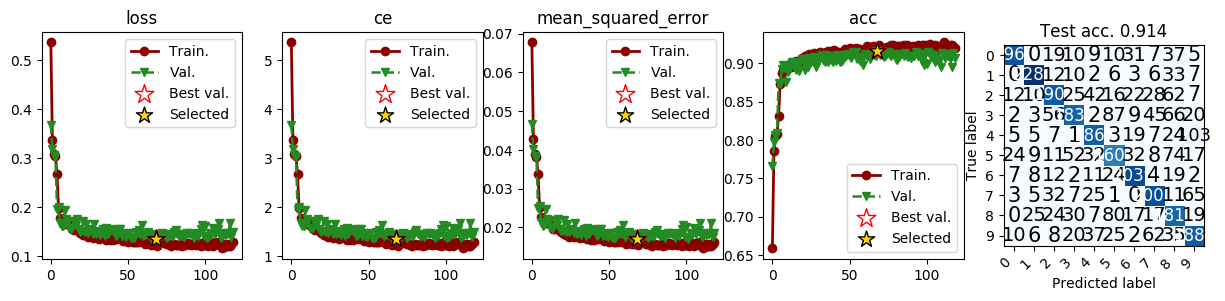

<Figure size 500x400 with 0 Axes>

Evaluating l2 regularization = 1e-07
Epoch 159, val_loss = 1.41e-01, val_acc = 0.91 Restoring model weights from the end of the best epoch
Epoch 160, val_loss = 1.42e-01, val_acc = 0.91 Epoch 00161: early stopping


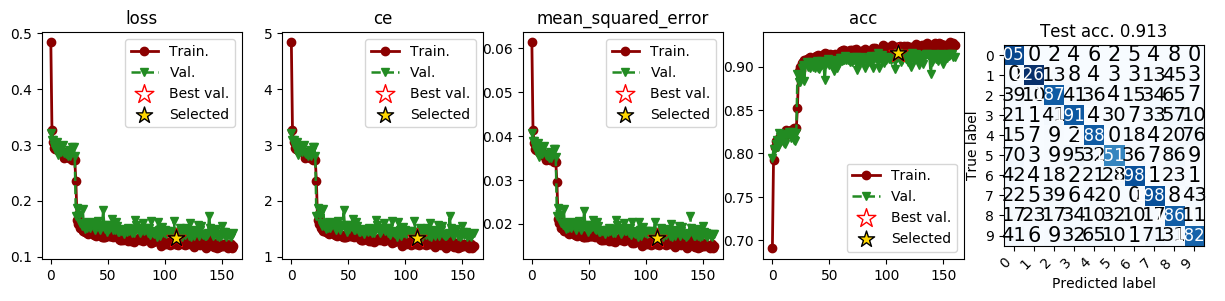

<Figure size 500x400 with 0 Axes>

Best l2 = 1e-09


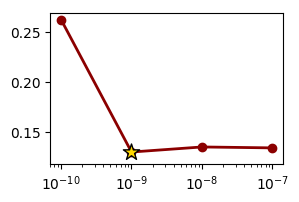

In [19]:
train_method = 'Supervised'

# In this dataset the best l2 parameter is 0.0
l2_list = numpy.array([0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1])
l2_list = numpy.array([1e-9])

model_supervised_list = []
val_losses = numpy.zeros_like(l2_list)
for i, l2 in enumerate(l2_list):
    print('Evaluating l2 regularization = {}'.format(l2))
    model = make_model(log_loss, l2=l2)
    history = model.fit(numpy.concatenate((*X_w_train_list, *X_wt_train_list)),
                        numpy.concatenate((*Y_w_train_list, *Y_wt_train_list)),
                        **fit_kwargs)

    plot_history(history, model, X_test, y_test)
    model_supervised_list.append(model)
    best_epoch = numpy.argmin(model.history.history['val_loss'])
    val_losses[i] = model.history.history['val_loss'][best_epoch]
    plt.show()

best_supervised = numpy.argmin(val_losses)
final_models[train_method] = model_supervised_list[best_supervised]
l2 = l2_list[best_supervised]
print('Best l2 = {}'.format(l2))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogx(l2_list, val_losses, 'o-')
ax.scatter(l2, val_losses[best_supervised], color='gold',
           edgecolor='black', marker='*', s=150, zorder=3)

# Our method with EM and original M

Train EM with all weak labels

q_0 weak = 0.150
q_1 weak = 0.150
q_2 weak = 0.150
q_3 weak = 0.150
q_4 weak = 0.150
q_5 weak = 0.150
q_0 true = 0.017
q_1 true = 0.017
q_2 true = 0.017
q_3 true = 0.017
q_4 true = 0.017
q_5 true = 0.017
Epoch 144, val_loss = 3.02e-01, val_acc = 0.81 Restoring model weights from the end of the best epoch
Epoch 145, val_loss = 2.95e-01, val_acc = 0.82 Epoch 00146: early stopping


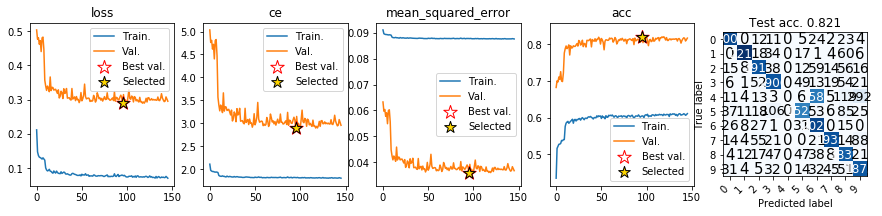

<Figure size 360x288 with 0 Axes>

In [9]:
def EM_log_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, K.epsilon(), 1.0-K.epsilon())
    Q = y_true * y_pred
    Z_em_train = Q / K.sum(Q, axis=-1, keepdims=True)
    out = -K.stop_gradient(Z_em_train)*K.log(y_pred)
    return K.mean(out, axis=-1)

model = make_model(EM_log_loss, l2=l2)

M_true_list = []
n_samples_train = X_w_train.shape[0] + X_wt_train.shape[0]
# Add weak samples
for i, M in enumerate(M_list):
    q = (X_w_train_list[i].shape[0]/n_samples_train)
    M_true_list.append(M * q)
    print('q_{} weak = {:.3f}'.format(i, q))
# Add true samples
M_supervised = computeM(n_classes, method='supervised')
for i, M in enumerate(M_list):
    q = (X_wt_train_list[i].shape[0]/n_samples_train)
    M_true_list.append(M_supervised * q)
    print('q_{} true = {:.3f}'.format(i, q))
    
M_true = numpy.concatenate(M_true_list)
last_index = 0
Z_train_index_list = []
V_train_list = []
# Add weak samples
for i in range(len(M_method_list)):
    Z_train_index_list.append(last_index + weak_to_index(Z_w_train_list[i], method=M_method_list[i]))
    last_index += len(M_list[i])
    V_train_list.append(M_true[Z_train_index_list[-1]])
# Add true samples
for i in range(len(M_method_list)):
    Z_train_index_list.append(last_index + weak_to_index(Y_wt_train_list[i], method='supervised'))
    last_index += n_classes
    V_train_list.append(M_true[Z_train_index_list[-1]])

history = model.fit(numpy.concatenate((*X_w_train_list, *X_wt_train_list)),
                    numpy.concatenate(V_train_list),
                    **fit_kwargs)
    
plot_history(history, model, X_test, y_test)

final_models['EM original M'] = model

# Our method with EM and estimated M

../wlc/WLweakener.py:504: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  S[weak_list, :] = alpha


q_0 weak = 0.150
q_1 weak = 0.150
q_2 weak = 0.150
q_3 weak = 0.150
q_4 weak = 0.150
q_5 weak = 0.150
q_0 true = 0.017
q_1 true = 0.017
q_2 true = 0.017
q_3 true = 0.017
q_4 true = 0.017
q_5 true = 0.017
Epoch 183, val_loss = 2.94e-01, val_acc = 0.82 Restoring model weights from the end of the best epoch
Epoch 184, val_loss = 2.89e-01, val_acc = 0.82 Epoch 00185: early stopping


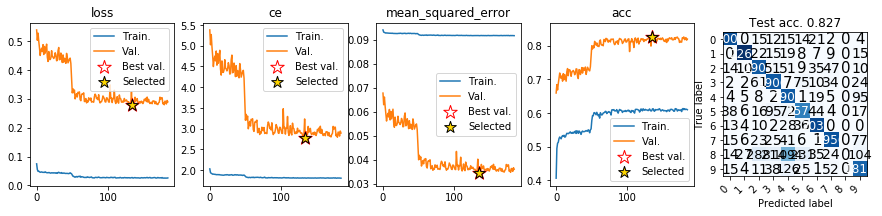

<Figure size 360x288 with 0 Axes>

In [10]:
from wlc.WLweakener import estimate_M
model = make_model(EM_log_loss, l2=l2)

M_estimated_list = []
n_samples_train = X_w_train.shape[0] + X_wt_train.shape[0]
# Add weak samples
for i in range(len(M_list)):
    M = estimate_M(Z_wt_train_list[i], Y_wt_train_list[i],
                   range(n_classes), reg='Partial', Z_reg=Z_w_train_list[i], alpha=1)
    q = (X_w_train_list[i].shape[0]/n_samples_train)
    M_estimated_list.append(M * q)
    print('q_{} weak = {:.3f}'.format(i, q))
# Add true samples
M_supervised = computeM(n_classes, method='supervised')
for i in range(len(M_list)):
    q = (X_wt_train_list[i].shape[0]/n_samples_train)
    M_estimated_list.append(M_supervised * q)
    print('q_{} true = {:.3f}'.format(i, q))
    
M_estimated = numpy.concatenate(M_estimated_list)
last_index = 0
Z_train_index_list = []
V_train_list = []
# Add weak samples
for i in range(len(M_method_list)):
    Z_train_index_list.append(last_index + weak_to_index(Z_w_train_list[i], method='random_weak'))
    last_index += 2**n_classes
    V_train_list.append(M_estimated[Z_train_index_list[-1]])
# Add true samples
for i in range(len(M_method_list)):
    Z_train_index_list.append(last_index + weak_to_index(Y_wt_train_list[i], method='supervised'))
    last_index += n_classes
    V_train_list.append(M_estimated[Z_train_index_list[-1]])

history = model.fit(numpy.concatenate((*X_w_train_list, *X_wt_train_list)),
                    numpy.concatenate(V_train_list),
                    **fit_kwargs)
    
plot_history(history, model, X_test, y_test)

final_models['EM estimated M'] = model

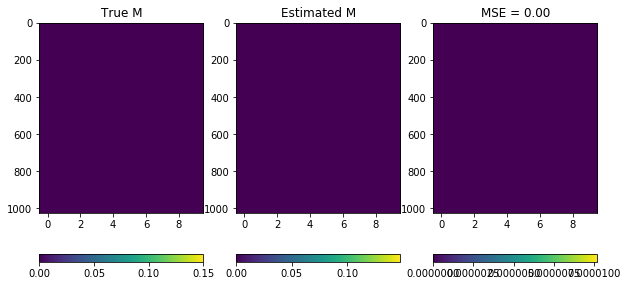

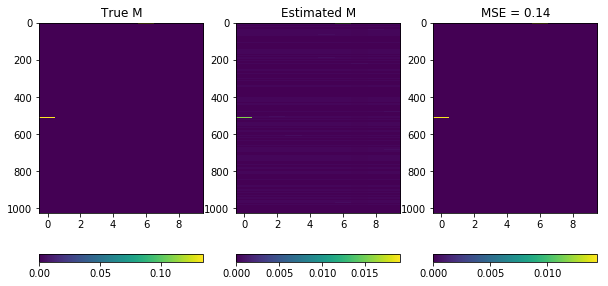

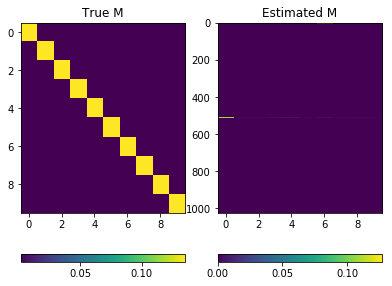

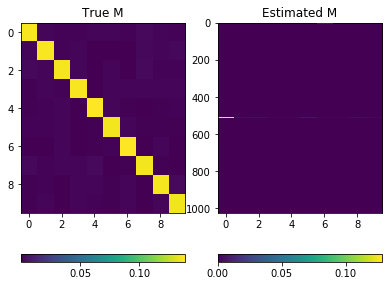

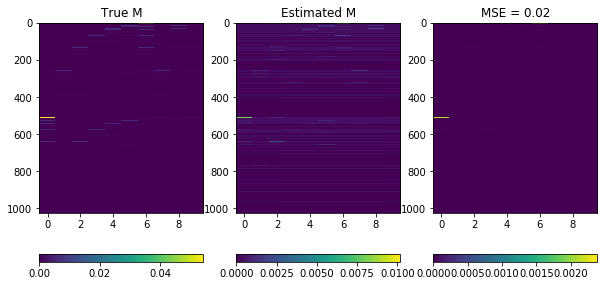

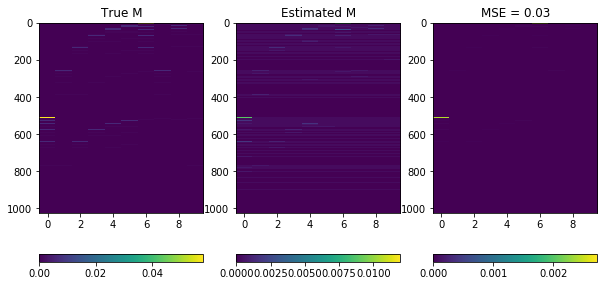

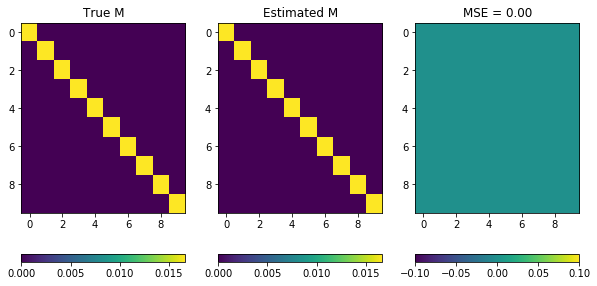

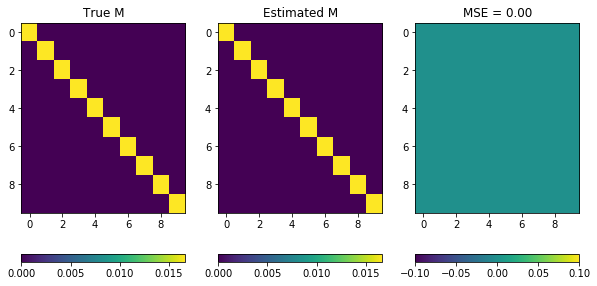

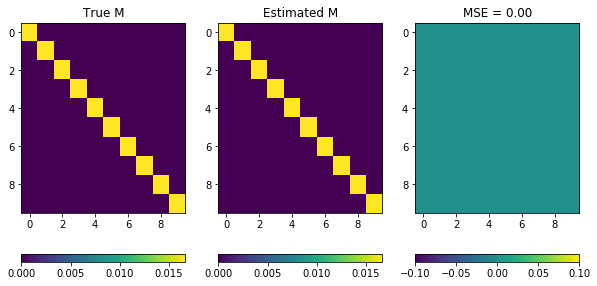

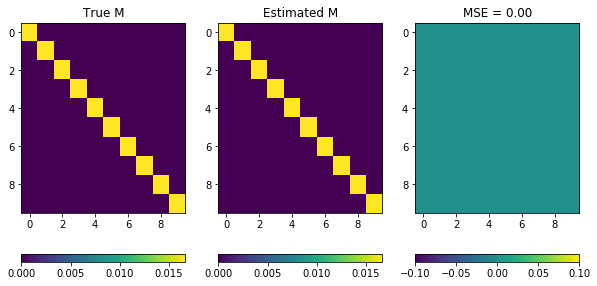

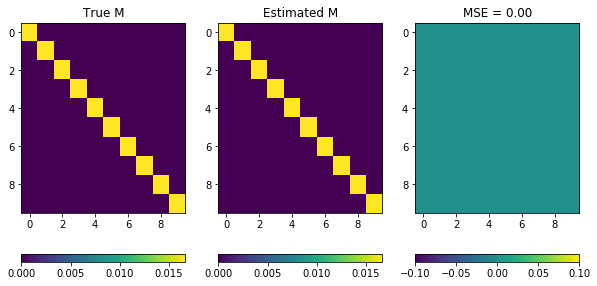

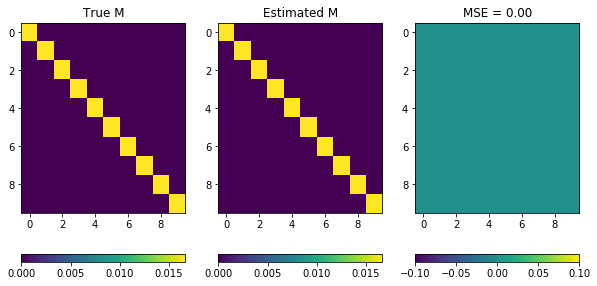

In [11]:
for i, (m1, m2) in enumerate(zip(M_true_list, M_estimated_list)):
    fig = plt.figure(figsize=(10, 5)) 
    ax = fig.add_subplot(1,3,1)
    ax.set_title('True M')
    cax = ax.imshow(m1, interpolation='nearest', aspect='auto')
    fig.colorbar(cax, orientation="horizontal")
    ax = fig.add_subplot(1,3,2)
    ax.set_title('Estimated M')
    cax = ax.imshow(m2, interpolation='nearest', aspect='auto')
    fig.colorbar(cax, orientation="horizontal")
    if m1.shape == m2.shape:
        mse = numpy.power(m1 - m2, 2).sum()
        ax = fig.add_subplot(1,3,3)
        ax.set_title('MSE = {:.2f}'.format(mse))
        cax = ax.imshow(numpy.power(m1 - m2, 2), interpolation='nearest', aspect='auto')
        fig.colorbar(cax, orientation="horizontal")

# Weak (lowerbound)

Epoch 229, val_loss = 1.46e-01, val_acc = 0.91 Restoring model weights from the end of the best epoch
Epoch 230, val_loss = 1.47e-01, val_acc = 0.91 Epoch 00231: early stopping


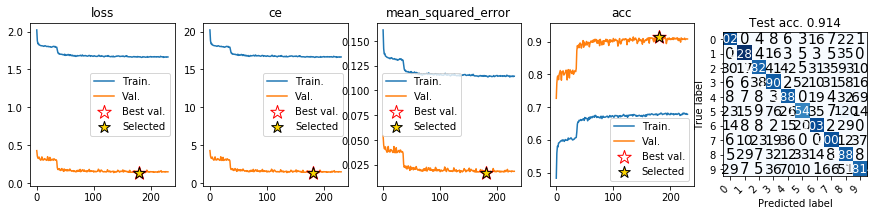

<Figure size 360x288 with 0 Axes>

In [12]:
model = make_model(log_loss, l2=l2)

history = model.fit(numpy.concatenate((*X_w_train_list, *X_wt_train_list)),
                    numpy.concatenate((*Z_w_train_list, *Y_wt_train_list)),
                    **fit_kwargs)

plot_history(history, model, X_test, y_test)

final_models['Weak'] = model

# Optimistic Superset Loss

Epoch 135, val_loss = 1.49e-01, val_acc = 0.91 Restoring model weights from the end of the best epoch
Epoch 136, val_loss = 1.49e-01, val_acc = 0.91 Epoch 00137: early stopping


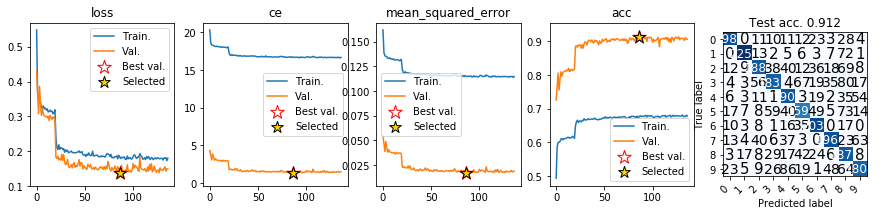

<Figure size 360x288 with 0 Axes>

In [13]:
def OSL_log_loss(y_true, y_pred):
    # Careful, I had to use a global variable here for the number of classes
    # for some reason I can not use y_osl.shape[-1] in the reshape function
    y_pred = K.clip(y_pred, K.epsilon(), 1.0-K.epsilon())
    y_osl = y_true * y_pred
    y_osl_max = K.max(y_osl, axis=-1)
    y_osl_max = K.repeat_elements(y_osl_max, n_classes, 0)
    y_osl_max = K.reshape(y_osl_max, (-1, n_classes))
    y_osl = K.cast(K.equal(y_osl, y_osl_max), y_pred.dtype)
    y_osl = y_osl / K.sum(y_osl, axis=-1, keepdims=True)
    out = -K.stop_gradient(y_osl) * K.log(y_pred)
    return K.mean(out, axis=-1)

model = make_model(OSL_log_loss, l2=l2)

history = model.fit(numpy.concatenate((*X_w_train_list, *X_wt_train_list)),
                    numpy.concatenate((*Z_w_train_list, *Y_wt_train_list)),
                    **fit_kwargs)
    
plot_history(history, model, X_test, y_test)

final_models['OSL'] = model

## Convex Loss for Partial Labels

def CLPL_log_loss(y_true, y_pred):
    # to implement
    return K.mean(out, axis=-1)

model = make_model(CLPL_log_loss, l2=l2)

history = model.fit(numpy.concatenate((*X_w_train_list, *X_wt_train_list)),
                    numpy.concatenate((*Z_w_train_list, *Y_wt_train_list)),
                    **fit_kwargs)
    
plot_history(history, model, X_test, y_test)

final_models['OSL'] = model

EM estimated M : 0.8266190476190476
EM original M : 0.8206190476190476
OSL : 0.9115238095238095
Supervised : 0.9153809523809524
Weak : 0.9142857142857143


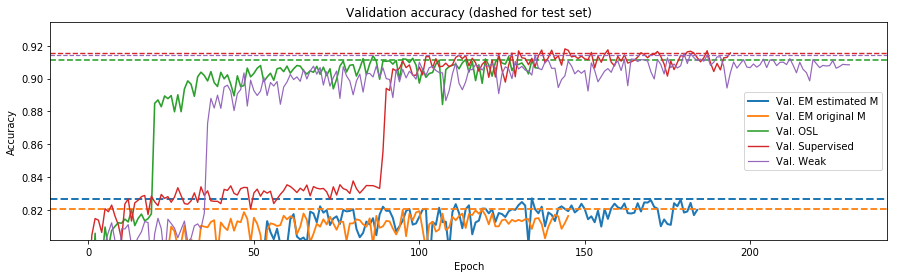

In [14]:
plt.figure(figsize=(15, 4))
lowest_acc = 1.0
highest_acc = 0.0
test_acc_dict = {}
for i, (key, model) in enumerate(sorted(final_models.items())):
    lw = (len(final_models)*2 - i)/5
    p = plt.plot(model.history.history['val_acc'], '-', lw=lw, label='Val. ' + key)
    test_acc = numpy.mean(model.predict_classes(X_test) == y_test)
    print('{} : {}'.format(key, test_acc))
    plt.axhline(y=test_acc, color=p[0].get_color(), lw=lw, linestyle='--')
    lowest_acc = test_acc if test_acc < lowest_acc else lowest_acc
    highest_acc = test_acc if test_acc > highest_acc else highest_acc
    test_acc_dict[key] = test_acc
plt.title('Validation accuracy (dashed for test set)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
range_acc = highest_acc - lowest_acc
plt.ylim([lowest_acc-range_acc*0.2, highest_acc+range_acc*0.2])
plt.legend()

# Save results and aggregate

- The following saves all the results of this experiment in a csv file
- And the next cell loads all the results with similar format and aggregates them in a final plot

In [15]:
export_dictionary = dict(
    dataset_name=dataset_name,
    random_state=random_state,
    train_prop=train_val_test_proportions[0],
    val_prop=train_val_test_proportions[1],
    test_prop=train_val_test_proportions[2],
    weak_prop=w_wt_drop_proportions[0],
    weak_true_prop=w_wt_drop_proportions[1],
    n_samples=n_samples,
    n_samples_train=n_samples_train,
    M_method_list='"' + ",".join(M_method_list) + '"',
    models='"' + ",".join(final_models.keys()) + '"',
    alpha=alpha,
    beta=beta,
    max_epochs=max_epochs,
)

import datetime

unique_file = 'Example_08_{}_a{}_r{:03.0f}_{}'.format(dataset_name, alpha*100, random_state,
                                              datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S'))

export_dictionary = {**export_dictionary, **test_acc_dict}
csv_text ="\n".join([k+','+str(v) for k,v in export_dictionary.items()])
#You can store this CSV string variable to file as below
with open(unique_file + "_summary.csv", "w") as file:
    file.write(csv_text)

List of files to aggregate
['./Example_07_mnist_a90.0_r000_2019_03_22_15_46_45_summary.csv']
('0.9', 'odd_even,random_weak,noisy,random_noise,IPL,quasi_IPL')


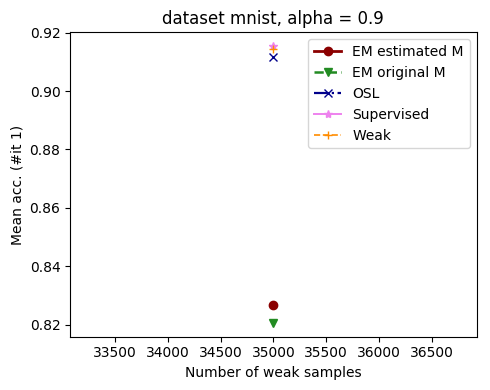

In [16]:
import os
import glob
import pandas

cmap = plt.cm.get_cmap('tab20')

from cycler import cycler
default_cycler = (cycler(color=['darkred', 'forestgreen', 'darkblue', 'violet', 'darkorange', 'saddlebrown']) +
                  cycler(linestyle=['-', '--', '-.', '-', '--', '-.']) + 
                  cycler(marker=['o', 'v', 'x', '*', '+', '.']) +
                  cycler(lw=[2, 1.8, 1.6, 1.4, 1.2, 1]))

plt.rcParams['figure.figsize'] = (3, 2)
plt.rcParams["figure.dpi"] = 100
plt.rc('lines', linewidth=1)
plt.rc('axes', prop_cycle=default_cycler)

files_list = glob.glob("./Example_08*summary.csv")
print('List of files to aggregate')
print(files_list)

list_ = []

for file_ in files_list:
    df = pandas.read_csv(file_,index_col=0, header=None, quotechar='"').T
    list_.append(df)

df = pandas.concat(list_, axis = 0, ignore_index = True)
df = df[df['dataset_name'] == dataset_name]
del df['dataset_name']
df_grouped = df.groupby(['alpha', 'M_method_list'])
for name, df_ in df_grouped:
    print(name)
    n_iterations = len(df_['random_state'].unique())
    columns = df_['models'].iloc[0].split(',')
    columns.append('n_samples_train')
    df_ = df_[columns]
    df_ = df_.apply(pandas.to_numeric)
    df_.index = df_['n_samples_train']
    del df_['n_samples_train']
    df_.sort_index(inplace=True)
    df_ = df_.groupby(df_.index).mean()
    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(111)
    for column in sorted(df_.columns):
        ax.plot(df_.index, df_[column], label=column)
    ax.set_title('dataset {}, alpha = {}'.format(dataset_name, name[0]))
    ax.set_ylabel('Mean acc. (#it {})'.format(n_iterations))
    ax.set_xlabel('Number of weak samples')
    ax.legend()
    fig.tight_layout()
    fig.savefig(os.path.join('Example_08_{}_a{:03.0f}.svg'.format(dataset_name,
                                                         float(name[0])*100)))